In [2]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

In [3]:
bioclim = pd.read_csv('data/csv/bioclim.csv')
bioclim = bioclim.drop(columns=['Unnamed: 0'])

crta_coords_filtered = pd.read_csv('data/csv/crta_coords_filtered.csv')
crta_coords_filtered.columns = ['lat', 'lon']
bioclim = pd.merge(bioclim, crta_coords_filtered, on=['lat', 'lon'])
bioclim = bioclim.drop_duplicates(subset=['lat', 'lon'])
bioclim = bioclim[bioclim['bio_13']!=-3.4e+38]
coords = bioclim[['lat', 'lon']]
bioclim = bioclim.drop(columns=['lat', 'lon'])
bioclim['group'] = 'osmia'
bioclim

,bio_13,bio_11,bio_9,bio_3,elev,bio_5,bio_6,bio_17,bio_10,bio_2,...,bio_1,bio_16,bio_8,bio_4,bio_19,bio_7,bio_14,bio_18,ndvi,group
0,82.0,1.100000,2.116667,29.925650,199,24.6,-2.3,125.0,18.533333,8.050000,...,9.683333,230.0,18.533333,710.95750,132.0,26.900000,36.0,230.0,0.157664,osmia
10,81.0,1.400000,2.483333,30.308643,117,24.9,-2.1,120.0,18.816666,8.183333,...,10.008333,227.0,18.816666,709.33014,125.0,27.000000,35.0,227.0,0.151344,osmia
45,71.0,1.800000,4.933333,31.550068,79,23.0,-1.3,129.0,17.350000,7.666666,...,9.391666,189.0,17.350000,634.90454,136.0,24.300000,35.0,189.0,0.178543,osmia
46,79.0,1.416667,2.500000,30.381304,106,25.1,-2.0,113.0,18.900000,8.233334,...,10.066667,220.0,18.900000,711.54870,121.0,27.100000,33.0,220.0,0.213319,osmia
54,74.0,2.416667,5.600000,33.741497,114,23.5,-1.0,147.0,17.450000,8.266666,...,9.758333,204.0,16.016666,611.29083,157.0,24.500000,43.0,200.0,0.289286,osmia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24203,64.0,2.066667,3.233333,33.107235,200,24.7,-1.1,109.0,18.383333,8.541667,...,10.029167,182.0,16.816668,663.19977,117.0,25.800001,35.0,165.0,0.241975,osmia
24204,67.0,2.250000,3.466667,33.460560,97,25.2,-1.0,117.0,18.733334,8.766666,...,10.333333,196.0,17.200000,669.74330,129.0,26.200000,38.0,175.0,0.259833,osmia
24205,76.0,2.566667,3.800000,32.403847,92,25.3,-0.7,116.0,19.133333,8.425000,...,10.687500,215.0,17.500000,674.28120,123.0,26.000000,37.0,192.0,0.220172,osmia
24206,64.0,1.983333,3.066667,30.981182,157,23.7,-1.1,125.0,17.916666,7.683333,...,9.800000,184.0,16.333334,648.14070,143.0,24.800001,41.0,165.0,0.302638,osmia


In [4]:
def add_scale_bar(ax, length=100, location=(0, 0), linewidth=5, units='km', text=True):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker
    import numpy as np
    import cartopy.crs as ccrs

    extent = ax.get_extent(crs=ccrs.PlateCarree())
    map_width_deg = extent[1] - extent[0]

    mid_lat = (extent[2] + extent[3]) / 2

    km_per_deg_at_lat = np.cos(np.radians(mid_lat)) * 111.32

    map_width_km = map_width_deg * km_per_deg_at_lat

    scale_bar_length_deg = (length / map_width_km) * map_width_deg
    
    x_start = location[0] * map_width_deg + extent[0]
    x_end = x_start + scale_bar_length_deg
    y_position = location[1] * (extent[3] - extent[2]) + extent[2]

    ax.plot([x_start, x_end], [y_position, y_position], transform=ccrs.PlateCarree(), color='k', linewidth=linewidth)
    
    if text==True:
        ax.text(x_end, y_position, ' '+f'{length} {units}', verticalalignment='bottom', horizontalalignment='left', transform=ccrs.Geodetic(), fontsize=10)


In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
# "#949494",
# colors = ['#DBDBDB', "#2f34c6", "#8386e2",  "#e17f7f", "#c62f2f", '#DBDBDB']
colors = ["#2f34c6", "#8386e2",  "#e17f7f", "#c62f2f"]
cmap_custom = LinearSegmentedColormap.from_list("cmap_custom", colors)
mpl.colormaps.register(cmap=cmap_custom, force=True)

/tmp/ipykernel_2367543/2499864880.py:7: UserWarning: Overwriting the cmap 'cmap_custom' that was already in the registry.
  mpl.colormaps.register(cmap=cmap_custom, force=True)


In [13]:
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

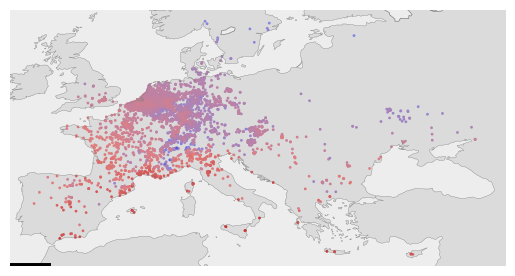

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_xlim(-10.11298075, 43)
ax.set_ylim(33.71471915, 61.16589785)
# plt.subplots(figsize=(10, 3), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='#DBDBDB', edgecolor='#DBDBDB', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

scatter = ax.scatter(coords['lon'], coords['lat'], transform=ccrs.PlateCarree(), 
           c=bioclim['bio_1'], s=1, cmap='cmap_custom', vmin=bioclim['bio_1'].min(), vmax = bioclim['bio_1'].max(), alpha = 1)
ax.axis('off')

# cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, fraction=0.15, aspect=25, shrink=0.55)



add_scale_bar(ax=ax, length=300, location=(0,0), text=False)

# plt.savefig('figures/maps/eur_temp_map.png', bbox_inches='tight', pad_inches=0, format='png', dpi=300)
# plt.savefig('figures/maps/eur_temp_map.svg', bbox_inches='tight', pad_inches=0, format='svg', dpi=300)

In [15]:
# plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()

# ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
# ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
# ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# ax.scatter(coords['lon'], coords['lat'], transform=ccrs.PlateCarree(), 
#            c=bioclim['bio_1'], s=2, cmap='Spectral_r', vmin=-1, vmax = 18)
# ax.axis('off')

In [32]:
america = pd.read_csv('data/csv/10k_america_bioclim_ndvi.csv', index_col=None)
america = america.drop(columns='Unnamed: 0')
america = america[america['bio_13']!= -3.4e+38]
america = america[america['elev']> 0]
# america['elev'] = np.log(america['elev'] + 1) # log transform
# america_points = america[['lat', 'lon']].reset_index(drop=True)
# # america = america.drop(columns=['lat', 'lon', 'bio_8', 'bio_4', 'bio_7'])
# america = america.drop(columns=['lat', 'lon'])b

#america['group'] = 'america'

america_in_range = america[(america['bio_1'] >bioclim['bio_1'].min()) & (america['bio_1'] <bioclim['bio_1'].max())]
america_out_of_range = america[(america['bio_1'] < bioclim['bio_1'].min()) | (america['bio_1'] > bioclim['bio_1'].max())]


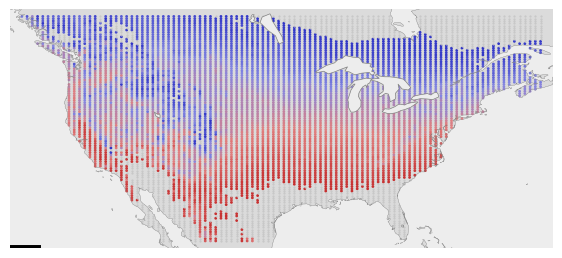

In [39]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
extent = [-131.53, -61.46, 24.09, 54.90]
ax.set_extent(extent, crs=ccrs.PlateCarree()) 
# plt.subplots(figsize=(10, 3), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='#DBDBDB', edgecolor='#DBDBDB', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(america_in_range['lon'], america_in_range['lat'], transform=ccrs.PlateCarree(), 
           c=america_in_range['bio_1'], s=1, cmap='cmap_custom', vmin=bioclim['bio_1'].min(), vmax = bioclim['bio_1'].max(), alpha = 1)

ax.scatter(america_out_of_range['lon'], america_out_of_range['lat'], transform=ccrs.PlateCarree(), 
           c='#c2c2c2', s=.2, alpha = 1)

ax.axis('off')

add_scale_bar(ax=ax, length=300, location=(0,0), text=False)

# plt.savefig('figures/maps/nam_temp_map_v2.png', format='png',  bbox_inches='tight', pad_inches=0, dpi=300)
